<a target="_blank" href="https://colab.research.google.com/github/skojaku/adv-net-sci/blob/main/notebooks/exercise-m05-clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Hands-on: Clustering

In [1]:
# If you are using Google Colab, uncomment the following line to install igraph
# !sudo apt install libcairo2-dev pkg-config python3-dev
# !pip install pycairo cairocffi
# !pip install igraph

## Modularity maximization

Let us showcase how to use `igraph` to detect communities with modularity. We will use the Karate Club Network as an example.

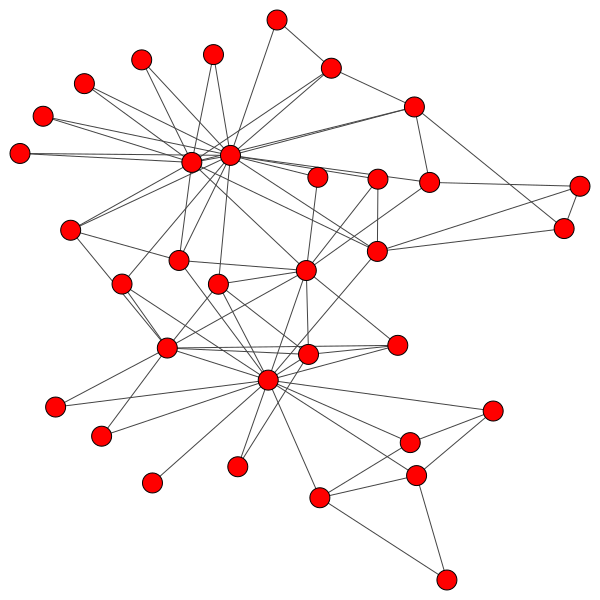

In [2]:
import igraph
g = igraph.Graph.Famous("Zachary")
igraph.plot(g, vertex_size=20)

When it comes to maximizing modularity, there are a variety of algorithms to choose from.
Two of the most popular ones are the `Louvain` and `Leiden` algorithms, both of which are implemented in `igraph`. The Louvain algorithm has been around for quite some time and is a classic choice, while the Leiden algorithm is a newer bee that often yields better accuracy. For our example, we'll be using the `Leiden` algorithm, and I think you'll find it really effective!

In [3]:
communities = g.community_leiden(resolution=1, objective_function= "modularity")

What is `resolution`? It is a parameter that helps us tackle the resolution limit of the modularity maximization algorithm {footcite}`fortunato2007resolution`!
In simple terms, when we use the resolution parameter $\rho$, the modularity formula can be rewritten as
 follow:

$$
Q(M) = \frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n \left(A_{ij} - \rho \frac{k_i k_j}{2m}\right) \delta(c_i, c_j)
$$

Here, the parameter $\rho$ plays a crucial role in balancing the positive and negative parts of the equation.
The resolution limit comes into play because of the diminishing effect of the negative term as the number of edges $m$ increases.
The parameter $\rho$ can adjust this balance and allow us to circumvent the resolution limit.

What is `communities`? This is a list of communities, where each community is represented by a list of nodes by their indices.

In [4]:
print(communities)


Clustering with 34 elements and 4 clusters
[0] 0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21
[1] 4, 5, 6, 10, 16
[2] 8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33
[3] 23, 24, 25, 27, 28, 31


Let us visualize the communities by coloring the nodes in the graph.

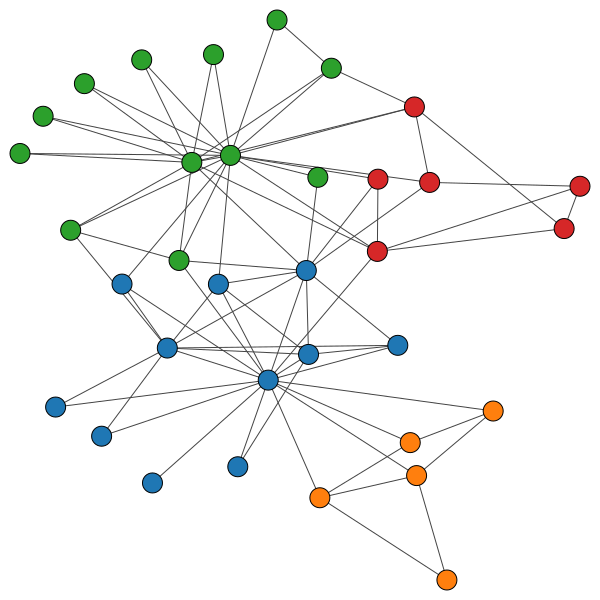

In [5]:
import seaborn as sns
community_membership = communities.membership
palette = sns.color_palette().as_hex()
igraph.plot(g, vertex_color=[palette[i] for i in community_membership])

- `community_membership`: This is a list of community membership for each node.
- `palette`: This is a list of colors to use for the communities.
- `igraph.plot(g, vertex_color=[palette[i] for i in community_membership])`: This plots the graph 'g' with nodes colored by their community.

### Exercise 01 🏋️‍♀️💪🧠

1. Select a network of your choice from [Netzschleuder](https://networks.skewed.de/). For convenience, choose a network of nodes less than 5000.
2. Download the csv version of the data by clicking something like "3KiB" under `csv` column.
3. Unzip the file and find "edges.csv", open it with a text editor to familiarize yourself with the format.
4. Load the data using `pandas`.
5. Get the source and target nodes from the data to create an edge list.
6. Construct a graph from the edge list, either using `igraph` or `scipy`.
7. Find communities by maximizing the modularity and visualize them.
8. Try at least three different values of the resolution parameter and observe how the community structure changes.

In [6]:
# Your code here

## Stochstic Block Model

Let us turn the SBM as our community detection tool using [graph-tool](https://graph-tool.skewed.de/). This is a powerful library for network analysis, with a focus on the stochastic block model.

In [7]:
#
# Uncomment the following code if you are using Google Colab
#
#!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
#!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
#!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
#!apt-get update
#!apt-get install python3-graph-tool python3-matplotlib python3-cairo
#!apt purge python3-cairo
#!apt install libcairo2-dev pkg-config python3-dev
#!pip install --force-reinstall pycairo
#!pip install zstandard

We will identify the communities using the stochastic block model as follows.
First, we will convert the graph object in igraph to that in graph-tool.

In [8]:
import graph_tool.all  as gt
import numpy as np
import igraph

# igraph object
g = igraph.Graph.Famous("Zachary")

# Set random seed for reproducibility
np.random.seed(42)

# Convert the graph object in igraph to that in graph-tool
edges = g.get_edgelist()
r, c = zip(*edges)
g_gt = gt.Graph(directed=False)
g_gt.add_edge_list(np.vstack([r, c]).T)

Then, we will fit the stochastic block model to the graph.

In [9]:
# Fit the stochastic block model
state = gt.minimize_blockmodel_dl(
     g_gt,
     state_args={"deg_corr": False, "B_min":2, "B_max":10},
)
b = state.get_blocks()

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/graph_tool/inference/blockmodel.py:390: UserWarning: unrecognized keyword arguments: ['B_min', 'B_max']
  warnings.warn("unrecognized keyword arguments: " +


- `B_min` and `B_max` are the minimum and maximum number of communities to consider.
- `deg_corr` is a boolean flag to switch to the degree-corrected SBM {footcite}`karrer2011stochastic`.


```{note}
Here's a fun fact: the likelihood maximization on its own can't figure out how many communities there should be. But `graph-tool` has a clever trick to circumvent this limitation.
`graph-tool` actually fits multiple SBMs, each with a different number of communities. Then, it picks the most plausible one based on a model selection criterion.
```

Let's visualize the communities to see what we got.

In [10]:
# Convert the block assignments to a list
community_membership = b.get_array()

# The community labels may consist of non-consecutive integers, e.g., 10, 8, 1, 4, ...
# So we reassign the community labels to be 0, 1, 2, ...
community_membership = np.unique(community_membership, return_inverse=True)[1]
community_membership

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

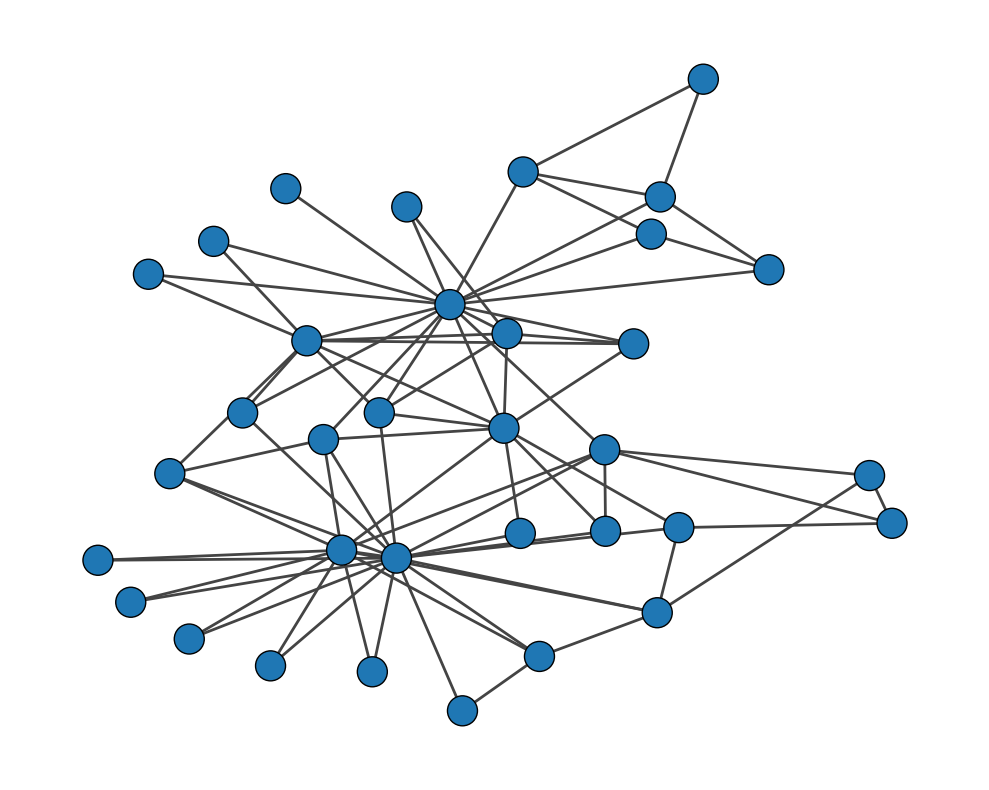

In [11]:
# Create a color palette
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette().as_hex()
# Plot the graph with nodes colored by their community
fig, ax = plt.subplots(figsize=(10, 8))
igraph.plot(
    g,
    target=ax,
    vertex_color=[palette[i] for i in community_membership],
)
plt.axis('off')
plt.tight_layout()
plt.show()

What we're seeing here isn't a failure at all. In fact, it's the best partition according to our stochastic block model. The model has discovered something called a **core-periphery structure** {footcite}`borgatti2000models`. Let me break that down:

- Think of a major international airport (the core) and smaller regional airports (the periphery).
- Major international airports have many flights connecting to each other (densely connected).
- Smaller regional airports have fewer connections among themselves (sparsely connected).
- Many regional airports have flights to major hubs (periphery connected to the core).

That's exactly what our model found in this network.

If we look at the adjacency matrix, we would see something that looks like an upside-down "L". This shape is like a signature for core-periphery structures.

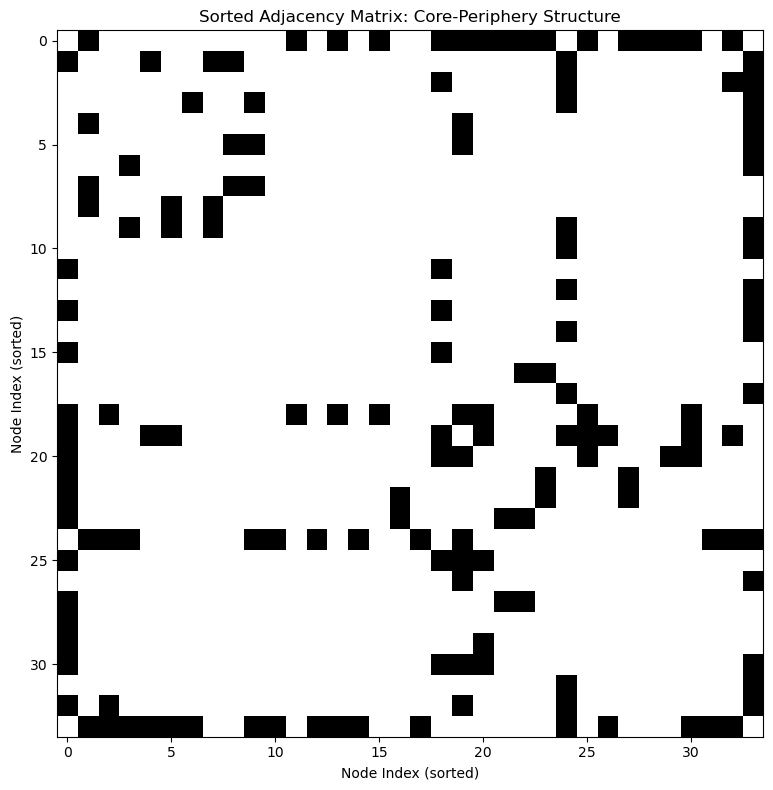

In [12]:
# Convert igraph Graph to adjacency matrix
A = np.array(g.get_adjacency().data)

# Sort nodes based on their community (core first, then periphery)
sorted_indices = np.argsort(community_membership)
A_sorted = A[sorted_indices][:, sorted_indices]

# Plot the sorted adjacency matrix
plt.figure(figsize=(10, 8))
plt.imshow(A_sorted, cmap='binary')
plt.title("Sorted Adjacency Matrix: Core-Periphery Structure")
plt.xlabel("Node Index (sorted)")
plt.ylabel("Node Index (sorted)")

plt.tight_layout()
plt.show()

### Exercise 02 🏋️‍♀️💪🧠

1. Select a network of your choice from [Netzschleuder](https://networks.skewed.de/). For convenience, choose a network of nodes less than 5000.
2. Download the csv version of the data by clicking something like "3KiB" under `csv` column.
3. Unzip the file and find "edges.csv", open it with a text editor to familiarize yourself with the format.
4. Load the data using `pandas`.
5. Get the source and target nodes from the data to create an edge list.
6. Construct a graph from the edge list, either using `igraph` or `scipy`.
7. Find communities by fitting the stochastic block model and visualize them.
8. Try `deg_corr=True` and compare the results with those from `deg_corr=False`.

```{footbibliography}
```---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Graph cut

Another approach from computer science is to treat a community detection problem as an *optimization* problem.
An early example is the **graph cut** problem, which asks to find the minimum number of edges to cut the graph into two disconnected components.

Specifically, let us consider cutting the network into two communities. Let $V_1$ and $V_2$ be the set of nodes in the two communities.
Then, the cut is the number of edges between the two communities, which is given by

$$
\begin{align}
\text{Cut}(V_1, V_2) = \sum_{i \in V_1} \sum_{j \in V_2} A_{ij}
\end{align}
$$

Now, the community detection problem is translated into **an optimization problem**, with the goal of finding a cut $V_1, V_2$ that minimizes $\text{Cut}(V_1, V_2)$.

The description of this problem is not complete 😈. Let's find out what is missing by playing with the optimization problem.

```{admonition} Exercise
:class: tip

Can you identify what is missing in the description of the graph cut problem? Without this, the best cut is trivial. {{ "<a href='BASE_URL/vis/community-detection/index.html?scoreType=graphcut&numCommunities=2&randomness=1&dataFile=two-cliques.json'>Graph Cut Problem 🎮</a>".replace('BASE_URL', base_url) }}

```{dropdown} Click to reveal the answer!

The missing element is a constraint: each community must contain at least one node. Without this, the trivial solution of placing all nodes in a single community would always yield a cut of zero.
```---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Modularity (Cont.)

:::{figure-md} fig-modularity-game

<img src="../figs/modularity.jpg" alt="Single node failure" width="100%">

Illustration of how modularity measures assortativity relative to a null model.
:::

Let's dive into the modularity formula! To put modularity into math terms, we need a few ingredients:
- $m$: The total number of strings (edges) in our bag
- $n$: The total number of balls (nodes) we have
- $A_{ij}$: This tells us if ball $i$ and ball $j$ are connected by a string
- $\delta(c_i,c_j)$: This is our color-checker. It gives us a 1 if balls $i$ and $j$ are the same color (same community), and 0 if they're different.

Now, the probability of pulling out a string out of $m$ string and finding matching colors on both ends is:

$$
\frac{1}{m} \sum_{i=1}^n \sum_{j=i+1}^n A_{ij} \delta(c_i,c_j) = \frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n A_{ij} \delta(c_i,c_j)
$$

We set $A_{ii} = 0$ by assuming our network doesn't have any "selfie strings" (where a ball is connected to itself). Also, we changed our edge counting a bit. Instead of counting each string once (which gave us $m$), we're now counting each string twice (once from each end). That's why we use $2m$ in the equation.

Now, imagine we've cut all the strings, and we're going to draw two balls at random with replacement.
Here's how our new bag looks:
- We have $2m$ balls in total ($1$ string has $2$ balls, and thus $m$ strings have $2m$ balls in total).
- A node with $k$ edges correspond to the $k$ of $2m$ balls in the bag.
- The color of each ball in our bag matches the color (or community) of its node in the network.

Now, what's the chance of pulling out two balls of the same color?

$$
\sum_{c=1}^C \left( \frac{1}{2m}\sum_{i=1}^n k_i \delta(c, c_i) \right)^2
$$

where $k_i$ is the degree (i.e., the number of edges) of node $i$, and $C$ is the total number of communities (i.e., colors).

Here's what it means in simple terms:
- We look at each color ($c$) one by one (the outer sum).
- For each color, we figure out how many balls of that color are in our bag ($\frac{1}{2m}\sum_{i=1}^n k_i \delta(c, c_i)$).
- We divide by $2m$ to get the probability of drawing a ball of that color.
- We then calculate the chance of grabbing that color twice in a row ($\left( \frac{1}{2m}\sum_{i=1}^n k_i \delta(c, c_i) \right)^2$).
- Finally, we add up these chances for all $C$ colors.

Putting altogether, the modularity is defined by

$$
\begin{align}
Q &=\frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n A_{ij} \delta(c_i,c_j) - \sum_{c=1}^C \left( \frac{1}{2m}\sum_{i=1}^n k_i \delta(c, c_i) \right)^2
\end{align}
$$

Equivalently, a standard expression is given by

$$
Q =\frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n \left[ A_{ij} -  \frac{k_ik_j}{2m} \right]\delta(c_i,c_j)
$$

```{note}

Are the two forms of modularity the same formula? Let's see how we can transform one into the other:

1. We start with our first form of modularity:

   $$
   Q =\frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n A_{ij} \delta(c_i,c_j) - \sum_{c=1}^C \left( \frac{1}{2m}\sum_{i=1}^n k_i \delta(c, c_i) \right)^2
   $$

2. First, let's factor out $\frac{1}{2m}$ from both terms:

   $$
   Q =\frac{1}{2m} \left[ \sum_{i=1}^n \sum_{j=1}^n A_{ij} \delta(c_i,c_j) - \frac{1}{2m}\sum_{c=1}^C \left( \sum_{i=1}^n k_i \delta(c, c_i) \right)^2 \right]
   $$

3. Now, here's a neat trick: $(\sum_i a_i)^2 = (\sum_i a_i)( \sum_j a_j)$. We can use this to expand the squared term:

   $$
   Q =\frac{1}{2m} \left[ \sum_{i=1}^n \sum_{j=1}^n A_{ij} \delta(c_i,c_j) - \frac{1}{2m}\sum_{c=1}^C \left( \sum_{i=1}^n k_i \delta(c, c_i) \right) \left( \sum_{j=1}^n k_j \delta(c, c_j) \right)\right]
   $$

4. And here is another trick $(\sum_i a_i)( \sum_j a_j) = \sum_i a_i \sum_j a_j = \sum_i \sum_j a_ia_j$

   $$
   Q =\frac{1}{2m} \left[ \sum_{i=1}^n \sum_{j=1}^n A_{ij} \delta(c_i,c_j) - \frac{1}{2m}\sum_{c=1}^C \left( \sum_{i=1}^n \sum_{j=1}^n k_i k_j  \delta(c, c_i)  \delta(c, c_j) \right)\right]
   $$

5. Here's yet another cool trick, $\delta(c,c_i) \delta(c, c_j) = \delta(c_i,c_j)$. This means we can simplify our expression:

   $$
   Q =\frac{1}{2m} \left[ \sum_{i=1}^n \sum_{j=1}^n A_{ij} \delta(c_i,c_j) -  \frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n k_i k_j  \delta(c_i,c_j) \right]
   $$

6. Finally, we can factor out the common parts:

   $$
   Q =\frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n \left[ A_{ij} -  \frac{k_ik_j}{2m} \right]\delta(c_i,c_j)
   $$
```


## Modularity Demo

Let's learn how the modularity works by playing with a community detection game!

```{admonition} Exercise 1
:class: tip

Find communities by maximizing the modularity. {{ "<a href='BASE_URL/vis/community-detection/index.html?scoreType=modularity&numCommunities=2&randomness=1&dataFile=two-cliques.json'>Modularity maximization (two communities) 🎮</a>".replace('BASE_URL', base_url) }}

```

One of the good things about modularity is that it can figure out how many communities there should be all by itself! 🕵️‍♀️ Let's have some fun with this idea. We're going to play the same game again, but this time, we'll start with a different number of communities. See how the modularity score changes as we move things around.

```{admonition} Exercise 2
:class: tip

Find communities by maximizing the modularity. {{ "<a href='BASE_URL/vis/community-detection/index.html?scoreType=modularity&numCommunities=4&randomness=1&dataFile=two-cliques.json'>Modularity maximization (four communities) 🎮</a>".replace('BASE_URL', base_url) }}
```

Now, let's take our modularity maximization for a real-world example! 🥋 We're going to use the famous karate club network. This network represents friendships between members of a university karate club. It's a classic in the world of network science, and it's perfect for seeing how modularity works in practice.

```{admonition} Exercise 3
:class: tip

Find communities by maximizing the modularity. {{ "<a href='BASE_URL/vis/community-detection/index.html?scoreType=modularity&numCommunities=4&randomness=0.25&dataFile=net_karate.json'>Modularity maximization (four communities) 🎮</a>".replace('BASE_URL', base_url) }}

```

## Limitation of Modularity

Like many other community detection methods, modularity is not a silver bullet. Thanks to extensive research, we know many limitations of modularity. Let's take a look at a few of them.

### Resolution limit

The modularity finds two cliques connected by a single edge as two separate communities.
But what if we add another community to this network?
Our intuition tells us that, because communities are *local* structure, the two cliques should remain separated by the modularity. But is this the case?

```{admonition} Exercise 4
:class: tip

Find communities by maximizing the modularity. {{ "<a href='BASE_URL/vis/community-detection/index.html?scoreType=modularity&numCommunities=3&randomness=0.9&dataFile=two-cliques-big-clique.json'>Modularity maximization (four communities) 🎮</a>".replace('BASE_URL', base_url) }}

```{dropdown} Click here to see the solution

The best modularity score actually comes from merging our two cliques into one big community. This behavior is what we call the **Resolution limit** {footcite}`fortunato2007resolution`. Modularity can't quite make out communities that are smaller than a certain size!

Think of it like this: modularity is trying to see the big picture, but it misses the little details. In network terms, the number of edges $m_c$ in a community $c$ has to be bigger than a certain size. This size is related to the total number of edges $m$ in the whole network. We write this mathematically as ${\cal O}(m)$.
```

### Spurious communities

What if the network does not have any communities at all? Does the modularity find no communities? To find out, let's run the modularity on a random network, where each pair of nodes is connected randomly with the same probability.

```{admonition} Exercise 5
:class: tip

Find communities by maximizing the modularity. {{ "<a href='BASE_URL/vis/community-detection/index.html?scoreType=modularity&numCommunities=3&randomness=0.8&dataFile=random-net.json'>Modularity maximization (four communities) 🎮</a>".replace('BASE_URL', base_url) }}

```{dropdown} Click here to see the solution

Surprise, surprise! 😮 Modularity finds communities even in our random network, and with a very high score too! It's like finding shapes in clouds - sometimes our brains (or algorithms) see patterns where there aren't any.

The wild thing is that the modularity score for this random network is even higher than what we saw for our network with two clear cliques!

This teaches us two important lessons:
1. We can't compare modularity scores between different networks. It's like comparing apples and oranges! 🍎🍊
2. A high modularity score doesn't always mean we've found communities.

Interested readers can read more about this in [this tweet by Tiago Peixoto](https://twitter.com/tiagopeixoto/status/1466352013856358400) and the discussion [here](https://reticular.hypotheses.org/1924).

<blockquote class="twitter-tweet" style="max-width: 550px;"><p lang="en" dir="ltr">Modularity maximization is not a reliable method to find communities in networks. Here&#39;s a simple example showing why:<br><br>1. Generate an Erdős-Rényi random graph with N nodes and average degree &lt;k&gt;.<br><br>2. Find the maximum modularity partition. <a href="https://t.co/MTt5DdFXSX">pic.twitter.com/MTt5DdFXSX</a></p>&mdash; Tiago Peixoto (@tiagopeixoto) <a href="https://twitter.com/tiagopeixoto/status/1466352013856358400?ref_src=twsrc%5Etfw">December 2, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
```


## So should we avoid modularity?

The simple answer is no. Modularity is still a powerful tool for finding communities in networks. Like any other method, it has its limitations. And knowing these limitations is crucial for using it effectively. There is "free lunch" in community detection {footcite}`peel2017ground`.

When these implicit assumptions are met, modularity is in fact a very powerful method for community detection. For example, it is in fact an "optimal" method for a certain class of networks {footcite}`nadakuditi2012graph`.

So, keep modularity in your toolbox. Just remember to use it wisely!

```{footbibliography}
```---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Modularity

**Modularity** is by far the most widely used method for community detection.
Modularity can be derived in many ways, but we will follow the one derived from assortativity.

## Assortativity

**Assortativity** is a measure of the tendency of nodes to connect with nodes of the same attribute.
The attribute, in our case, is the community that the node belongs to, and we say that a network is assortative if nodes of the same community are more likely to connect with each other than nodes of different communities.

Let's think about assortativity by using color balls and strings! 🎨🧵

Imagine we're playing a game as follows:

1. Picture each connection in our network as two colored balls joined by a piece of string. 🔴🟢--🔵🟡
2. The color of each ball shows which community it belongs to.
3. Now, let's toss all these ball-and-string pairs into a big bag.
4. We'll keep pulling out strings with replacement and checking if the balls on each end match colors.

The more color matches we find, the more assortative our network is. But, there's a catch!
What if we got lots of matches just by luck? For example, if all our balls were the same color, we'd always get a match. But that doesn't tell us much about our communities.
So, to be extra clever, we compare our results to a "random" version (null model):

1. We snip all the strings and mix up all the balls.
2. Then we draw pairs of balls at random *with replacement* and see how often the colors match.

By comparing our original network to this mixed-up version, we can see if our communities are really sticking together more than we'd expect by chance.
This comparison against the random version is the heart of modularity. Unlike graph cut methods that aim to maximize assortativity directly, modularity measures assortativity *relative* to *a null model*.

:::{figure-md} fig-modularity-game

<img src="../figs/modularity.jpg" alt="Single node failure" width="100%">

Illustration of how modularity measures assortativity relative to a null model.
:::

## Deriving Modularity

Now, let's put on our math hats and make this colorful game a bit more precise.

Let's introduce some helpful symbols to describe our network:
- $N$: This is our total number of nodes (or balls in our game)
- $M$: The number of edges (or strings) connecting our nodes
- $A_{ij}$: Adjacency matrix. If $A_{ij} = 1$, it means node $i$ and node $j$ are connected. If $A_{ij} = 0$, they're not connected.
- $k_i$: Degree of node $i$, i.e., how many edges a node has.
- $c_i$: Community of node $i$, i.e., which community a node belongs to.
- $\delta(c_i, c_j)$: Kronecker delta function. It gives us 1 if nodes $i$ and $j$ are the same color, and 0 if they're different.

```{admonition} Exercise
:class: tip

What is the probability of color matches for a given network? Derive the probability by using $\sum, M, A_{ij}, \delta(c_i, c_j)$.

```{dropdown} Hint
Let's think about our colorful bag of balls and strings! 🎨🧵
First, ask yourself:
1. How many strings do we have in total? (This is our M!)
2. Now, out of all these strings, how many are the same color on both ends?
```

```{admonition} Exercise
:class: tip

What is the probability of color matches for the random version? Derive the probability by using $\sum, M, \delta(c_i, c_j), k_i,k_j$.

```{dropdown} Hint
1. Imagine a big bag full of colorful balls, but this time without any strings. 🔴🟢🔵🟡
2. Now, think about picking one ball out of the bag. What are the chances of picking a specific color?
3. Then, put that ball back and pick another one. What are the odds this second ball matches the color of the first one?

```

The full modularity formula is on the next page 😉.---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Community detection (pattern matching)

Community detection is an abstract unsupervised problem. It is abstract because there is no clear-cut definition or ground truth to compare against. The concept of a community in a network is subjective and highly context-dependent.

A classical approach to community detection is based on *pattern matching*.
Namely, we first explicitly define a community by a specific connectivity pattern of its members. Then, we search for these communities in the network.

:::{figure-md} clique

<img src="https://pythonhosted.org/trustedanalytics/R_images/k-clique_201508281155.png" alt="Clique graph" width="80%">

Cliques of different sizes. Taken from [https://pythonhosted.org/trustedanalytics/python_api/graphs/graph-/kclique_percolation.html](https://pythonhosted.org/trustedanalytics/python_api/graphs/graph-/kclique_percolation.html)
:::

Perhaps, the strictest definition of a community is a *clique*: a group of nodes all connected to each other. Examples include triangles (3-node cliques) and fully-connected squares (4-node cliques).
However, cliques are often too rigid for real-world networks. In social networks, for instance, large groups of friends rarely have every member connected to every other, yet we want to accept such "in-perfect" social circles as communities.
This leads to the idea of relaxed versions of cliques, called **pseudo-cliques**.

Pseudo-cliques are defined by relaxing at least one of the following three dimensions of strictness:

1. Degree: Not all nodes need to connect to every other node.
   - **$k$-plex**: each node connects to all but $k$ others in the group {footcite}`seidman1978graph`.
   - **$k$-core**: each node connects to $k$ others in the group {footcite}`seidman1983network`.
2. Density: The overall connection density can be lower.
   - **$\rho$-dense subgraphs**, with a minimum edge density of $\rho$ {footcite}`goldberg1984finding`.
3. Distance: Nodes can be further apart.
   - **$n$-clique**, where all nodes are within n steps of each other {footcite}`luce1950connectivity`.
4. Combination of the above:
   - **n-clan** and **n-club** {footcite}`mokken1979cliques`
   - **$k$-truss**, a maximal subgraph where all edges participate in at least $k-2$ triangles {footcite}`saito2008extracting,cohen2009graph,wang2010triangulation`.
   - **$\rho$-dense core**, a subgraph with minimum conductance $\rho$ {footcite}`koujaku2016dense`.

:::{figure-md} clique-pattern

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0378873315000520-gr1.jpg" alt="Pseudo-clique patterns" width="80%" style="display: block; margin-left: auto; margin-right: auto;">


Illustation of different pseudo cliques. Taken from {footcite}`koujaku2016dense`.

:::


```{footbibliography}
```
# Pen and Paper

✍️ [Pen and Paper Exercise](./pen-and-paper/exercise.pdf) 🚢
---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Balanced cut

## Ratio Cut

Graph cut often provide unbalanced communities, e.g., a community consisting of a single node, and another consisting of all other nodes. For example, if the network has a node with degree one (e.g., one edge), an optimal cut will be to place this node in its own community, resulting in a cut of one.

**Ratio cut** addresses this issue by introducing a normalization factor to balance the cut.
Suppose we cut the network into two communities $V_1$ and $V_2$, then the ratio cut is defined as

$$
\text{Ratio cut}(V_1, V_2) = \frac{1}{|V_1| \cdot |V_2|} \sum_{i \in V_1} \sum_{j \in V_2} A_{ij}
$$

- $|V_1|$ (or |V_2|) is the number of nodes in the community $V_1$ (or $V_2$).

The normalization factor $1/(|V_1| |V_2|)$ balances the community sizes. It's smallest when communities are equal ($|V_1| = |V_2|$) and largest when one community has only one node ($|V_1| = 1$ or $|V_2| = 1$).

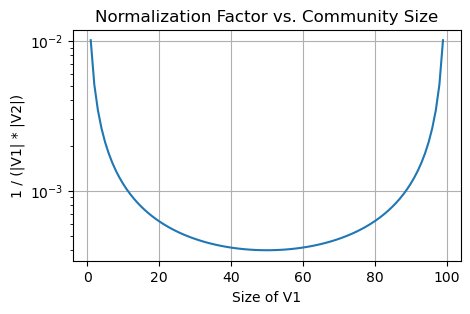

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Total number of nodes
total_nodes = 100

# Create an array of possible sizes for V1
V1_sizes = np.arange(1, total_nodes)

# Calculate corresponding sizes for V2
V2_sizes = total_nodes - V1_sizes

# Calculate the normalization factor
normalization_factor = 1 / (V1_sizes * V2_sizes)

# Create the plot
fig = plt.figure(figsize=(5, 3))
plt.plot(V1_sizes, normalization_factor)
plt.title('Normalization Factor vs. Community Size')
plt.xlabel('Size of V1')
plt.ylabel('1 / (|V1| * |V2|)')
plt.yscale('log')  # Use log scale for y-axis due to large range of values
plt.grid(True)

## Normalized cut

**Normalized cut**{footcite}`shi2000normalized` balances communities based on edge count, unlike Ratio cut which uses node count. It is defined as:

$$
\text{Normalized cut}(V_1, V_2) = \frac{1}{|E_1| \cdot |E_2|} \sum_{i \in V_1} \sum_{j \in V_2} A_{ij}
$$

- $|E_1|$ and $|E_2|$ are the number of edges in the communities $V_1$ and $V_2$, respectively.



```{admonition} Exercise
:class: tip

Compute the ratio cut and normalized cut for the following network. The red edges should be cut.

```{glue:figure} fig-graph-cut
:name: fig-graph-cut

```

```{dropdown} Click here to reveal the answer

The graph consists of two cliques, each with 5 nodes ($|V_1| = |V_2| = 5$).
Each clique has 10 internal edges and 2 edges connecting to the other clique.
Therefore, $|E_1| = |E_2| = 10 + 2 = 12$.
We can now calculate:

- **Ratio cut**: $2 / (5 \times 5) = 0.08$.
- **Normalized cut**: $2 / (12 \times 12) = 0.01388889$.

```

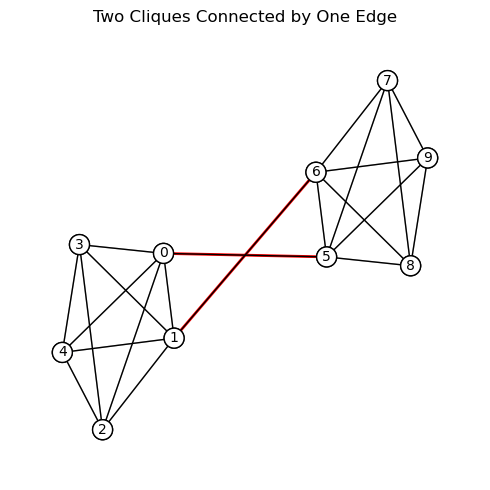

In [14]:
import igraph as ig
import matplotlib.pyplot as plt
from myst_nb import glue

# Create two cliques of size 5
G1 = ig.Graph.Full(5)
G2 = ig.Graph.Full(5)

# Combine the two cliques
G = G1 + G2

# Add an edge between the two cliques
G.add_edge(0, 5)
G.add_edge(1, 6)

# Draw the graph
layout = G.layout_fruchterman_reingold()

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Draw the connecting edge in red
ig.plot(
    G,
    target=ax,
    layout=layout,
    vertex_color='lightblue',
    vertex_size=20,
    edge_color='gray',
    edge_width=1
)

# Draw the connecting edge in red behind the graph
ax.plot([layout[0][0], layout[5][0]], [layout[0][1], layout[5][1]], color='red', linewidth=2, zorder=0)
ax.plot([layout[1][0], layout[6][0]], [layout[1][1], layout[6][1]], color='red', linewidth=2, zorder=0)

ig.plot(
    G,
    target=ax,
    layout=layout,
    vertex_color='white',
    vertex_size=20,
    edge_color='black',
    edge_width=1
)

# Add labels to the nodes
for i, coords in enumerate(layout):
    ax.annotate(str(i), coords, ha='center', va='center')

plt.title("Two Cliques Connected by One Edge")
plt.axis('off')
plt.tight_layout()

glue("fig-graph-cut", fig, display=False)

## Cut into more than two communities

Ratio cut and Normalized cut can be extended to cut into more than two communities. Specifically, we can extend them to cut into $k$ communities, i.e., $V_1, V_2, \dots, V_k$ by defining

$$
\begin{align}
\text{Ratio cut}(V_1, V_2, \dots, V_k) &= \sum_{k=1}^K \frac{1}{|V_k|} \left(\sum_{i \in V_k} \sum_{j \notin V_{k}} A_{ij} \right) \\
\text{Normalized cut}(V_1, V_2, \dots, V_k) &= \sum_{k=1}^K \frac{1}{|E_k|} \left(\sum_{i \in V_k} \sum_{j \notin V_{k}} A_{ij} \right)
\end{align}
$$

## Algorithms to find the best cut

For both ratio and normalized cut, finding the best cut is a NP-hard problem. Yet, there are some heuristics to find a good cut.
Interested students are encouraged to refer to [Ulrike von Luxburg "A Tutorial on Spectral Clustering"](https://arxiv.org/abs/0711.0189) for more details.

## Issue of Ratio cut and Normalized cut

While Ratio cut and Normalized cut methods are clever approaches, they do come with a couple of challenges we should be aware of.

Firstly, these methods ask us to decide upfront how many communities we want to find. This can be tricky because, in real-world networks, we often don't know this number in advance. It requires us to make a guess on how many different groups of friends we have before actually looking at our social circle.

Secondly, and perhaps more critically, these methods *favor* communities of roughly the same size.
It's as if they're assuming all our friend groups should have about the same number of people.
But as we know from real life, that's not always the case.
Some of us might have a large group of college friends and a smaller group of childhood buddies.
Research has shown that in many real-world networks, communities can indeed be quite different in size {footcite}`palla2005uncovering,clauset2004finding`.

These limitations don't mean these methods should not be used, but they do remind us the importance of understanding the underlying assumptions and limitations of methods we use 😉.
It's always good to keep these points in mind when we're working with network data. 🕸️💡

```{footbibliography}
```---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Stochastic Block Model

Let's talk about two ways to look at communities in networks.

In modularity maximization, we are given a network and asked to find the best way to group its parts into communities.

Let's flip that idea on its head! 🙃 Instead of starting with a network and looking for communities, we start with the communities and ask, *"What kind of network would we get if the nodes form these communities?"*. This is the idea of the **Stochastic Block Model (SBM)**.

While modularity maximization is about finding hidden patterns, SBM is about imagining what a network would look like based on a given community structure. Two sides of the same coin, each giving us a unique perspective on community detection.

## Model

In stochastic block model, we describe a network using probabilities given a community structure. Specifically, let us consider two nodes $i$ and $j$ who belong to community $c_i$ and $c_j$. Then, the probability of an edge between $i$ and $j$ is given by their community membership.

$$
P(A_{ij}=1|c_i, c_j) = p_{c_i,c_j}
$$

where $p_{c_i,c_j}$ is the probability of an edge between nodes in community $c_i$ and $c_j$, respectively.
Notice that the edge probability is fully specified by the community membership of the nodes.
This means that nodes in a community are connected with the same probability irrespective of the nodes themselves, and the nodes in different two communities are also connected with the same probability.
As a result, when plotting the adjacency matrix, we observe "blocks" of different edge densities, which is why we say that SBM is a "block model".

```{code-cell} ipython3
:tags: [hide-input]

import numpy as np
import matplotlib.pyplot as plt

import igraph

# Generate SBM
n, k = 900, 3

# Create block sizes (equal for simplicity)
block_sizes = [n // k] * k

# Create diverse pref matrix
pref_matrix = [
    [0.3, 0.05, 0.1],
    [0.05, 0.4, 0.02],
    [0.1, 0.02, 0.35]
]

# Generate SBM using igraph
g = igraph.Graph.SBM(n, pref_matrix, block_sizes)

# Convert to adjacency matrix for visualization
A = np.array(g.get_adjacency().data)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(A, cmap='binary')
plt.title("Adjacency Matrix of Stochastic Block Model")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.tight_layout()
plt.show()

```


## Characterizing network structures with the SBM

Stochastic Block Model is a flexible model that can be used to describe a wide range of network structures.

Let's start with communities where nodes within a community are more likely to be connected to each other than nodes in different communities. We can describe this using SBM by:

$$
P_{c,c'} = \begin{cases}
    p_{\text{in}} & \text{if } c = c' \\
    p_{\text{out}} & \text{if } c \neq c'
\end{cases}
$$

-  $p_{\text{in}}$ is the chance of a connection between nodes in the same community
- $p_{\text{out}}$ is the chance of a connection between nodes in different communities

Usually, we set $p_{\text{in}} > p_{\text{out}}$, because nodes in the same community tend to be more connected.

But, there's more SBM can do:

1. **Disassortative communities**: What if we flip things around and set $p_{\text{in}} < p_{\text{out}}$? Now we have communities where nodes prefer to connect with nodes from other communities. This is not in line with the communities we have focused on so far. Yet, it is still a valid model of community structure, and SBM allows for this generalization of community structure easily.

2. **Random networks**: If we make $p_{\text{in}} = p_{\text{out}}$, we get a completely random network where every node has an equal chance of connecting to any other node. This is what we call an Erdős-Rényi network.

In sum, SBM has been used as a playground for network scientists. We can use it to create many interesting network structures and study how they behave.

## Generating networks with SBM

It is easy to generate networks with SBM using igraph.
For example, the assortativity communities can be generated as follows.

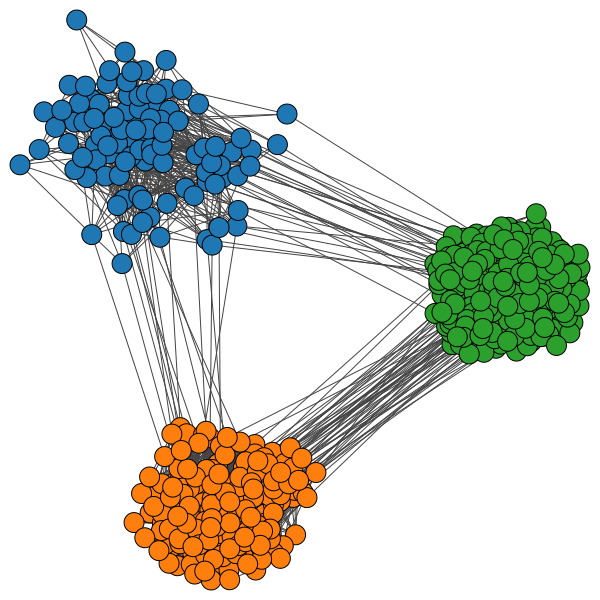

In [15]:
import igraph

p_in = 0.1
p_out = 0.001
block_sizes = [100, 200, 300]
n = sum(block_sizes)

pref_matrix = [
    [p_in, p_out, p_out],
    [p_out, p_in, p_out],
    [p_out, p_out, p_in]
]

g = igraph.Graph.SBM(n, pref_matrix, block_sizes)

# Plot the network
import seaborn as sns
palette = sns.color_palette()

community_colors = sum([[palette[i]] * block_sizes[i] for i in range(len(block_sizes))], [])
igraph.plot(g, vertex_color=community_colors)

- `pref_matrix` is the matrix of connection probabilities between communities. Its $(i,j)$th-element is the probability of a connection between nodes in community $i$ and $j$.


## Detecting communities with SBM

Imagine you're a detective trying to figure out how a network was created. You have a hunch about the community structure, and you want to know if it matches the network you see. That's exactly what we're going to do to find out communities!

Here's how we can describe the probability of seeing a particular network, given a community structure:

$$
P(\left\{A_{ij}\right\}_{ij}) = \prod_{i<j} P(A_{ij}=1|c_i, c_j)^{A_{ij}} (1-P(A_{ij}=1|c_i, c_j))^{1-A_{ij}}
$$

Let's break this down into simpler terms:

- First, $\left\{A_{ij}\right\}_{ij}$ is just a fancy way of saying "all the connections in our network". Think of it as a big table showing who's connected to whom.

- We use $\prod_{i < j}$ instead of $\prod_{i,j}$ because we're dealing with an undirected network. This means if Alice is friends with Bob, Bob is also friends with Alice. We only need to count this friendship once, not twice!

- The last part, $P(A_{ij}=1|c_i, c_j)^A_{ij}(1-P(A_{ij}=1|c_i, c_j))^{1-A_{ij}}$, might look scary, but it's actually quite clever. It's a shorthand way of saying "what's the chance of this connection existing or not existing?" If the connection exists ($A_{ij}=1$), we use the first part. If it doesn't ($A_{ij}=0$), we use the second part. It's a two-in-one formula.

Here's a neat trick we can use to make our lives easier. We can take the logarithm of both sides of our equation. This turns our big product (multiplication) into a simpler sum (addition).

$$
{\cal L}=\log P(\left\{A_{ij}\right\}_{ij}) = \sum_{i<j} A_{ij} \log P(A_{ij}=1|c_i, c_j) + (1-A_{ij}) \log (1-P(A_{ij}=1|c_i, c_j))
$$

We call this the **likelihood function**. It tells us how likely we are to see this network given our community guess. We can play around with different community assignments and edge probabilities to see which one gives us the highest likelihood.
To make this game easier, let's first figure out the best edge probabilities for a given community assignment.

Our likelihood function has a special shape - it is *a concave function* with respect to $p_{c,c'}$. This means that the likelihood function is a hill with only one peak when we look at it in terms of edge probability $p_{c,c'}$.

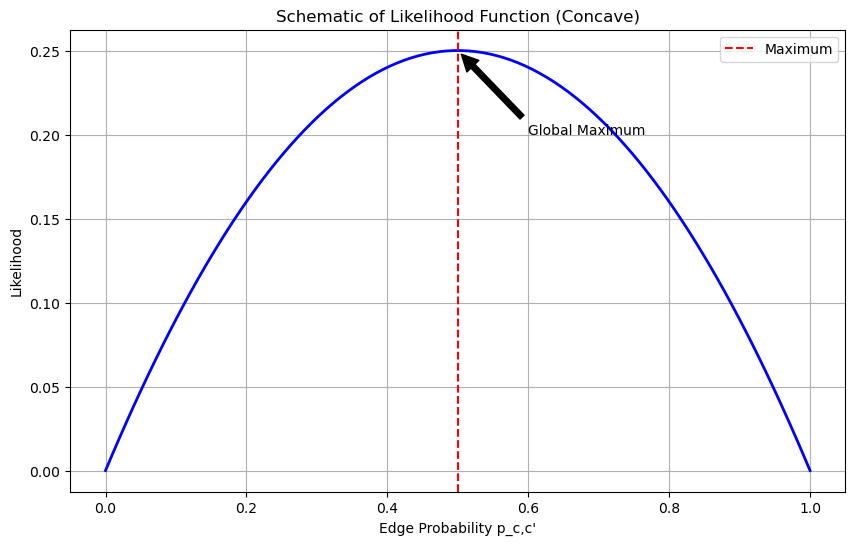

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def concave_function(x):
    return -(x - 0.5)**2 + 0.25

x = np.linspace(0, 1, 100)
y = concave_function(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.title('Schematic of Likelihood Function (Concave)')
plt.xlabel('Edge Probability p_c,c\'')
plt.ylabel('Likelihood')
plt.axvline(x=0.5, color='r', linestyle='--', label='Maximum')
plt.annotate('Global Maximum', xy=(0.5, 0.25), xytext=(0.6, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()
plt.grid(True)
plt.show()

So, what does this mean for us? The top of this hill (our maximum value) is flat, and there's only one flat spot on the whole hill. So if we can find a spot where the hill isn't sloping at all (that's what we mean by "zero gradient"), we've found the very top of the hill! 🏔️

In math terms, we take the derivative of our likelihood function with respect to $p_{c,c'}$ and set it to zero, i.e., $\partial {\cal L}  / \partial p_{cc'} = 0$. Here is what we get:


$$
\begin{aligned}
\frac{\partial {\cal L}}{\partial p_{c,c'}} &= 0 \\
\Rightarrow & \sum_{i<j} \left[A_{ij} \frac{1}{p_{c_i,c_j}} \delta(c_i,c)\delta(c_j,c') -(1-A_{ij}) \frac{1}{1-p_{c_i,c_j}}\delta(c_i,c')\delta(c_j,c') \right] = 0 \\
\Rightarrow &
\frac{m_{cc'}}{p_{c_i,c_j}} - \frac{\sum_{i < j} \delta(c_i,c)\delta(c_j,c') }{1-p_{c_i,c_j}} = 0 & \text{if } c \neq  c' \\
\Rightarrow & p_{c,c'} = \frac{m_{cc'}}{\sum_{i < j} \delta(c_i,c)\delta(c_j,c')}
\end{aligned}
$$

Let's break down these equations:

- $m_{cc'}$ is the number of edges between nodes in community $c$ and those in community $c'$.
- The derivative $\partial \log p_{cc} / \partial p_{cc}$ is just $1/p_{cc}$.

The denominator $\sum_{i < j} \delta(c_i,c)\delta(c_j,c')$ is the total number of pairs of nodes that belong to communities $c$ and $c'$. It is given by


$$
\sum_{i < j} \delta(c_i,c)\delta(c_j,c') =
\begin{cases}
n_cn_{c'} & \text{if } c \neq c' \\
\frac{n_c (n_c - 1)}{2} & \text{if } c = c'
\end{cases}
$$

Why do we have two different equations for $p_{c,c'}$? It's because we are counting each pair of nodes only by once. It is easy to verify when looking at the adjacency matrix:

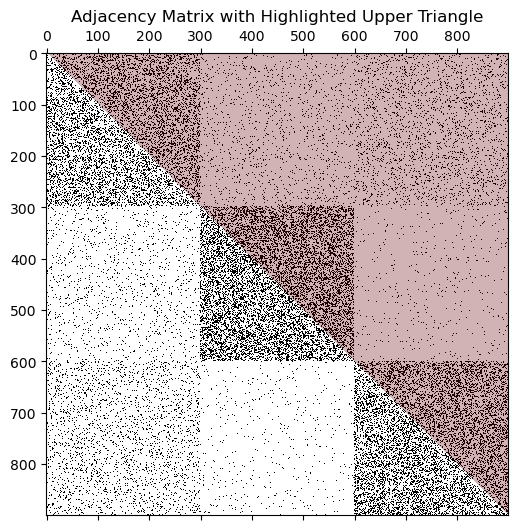

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import igraph

# Generate SBM
n, k = 900, 3

# Create block sizes (equal for simplicity)
block_sizes = [n // k] * k

# Create diverse pref matrix
pref_matrix = [
    [0.3, 0.05, 0.1],
    [0.05, 0.4, 0.02],
    [0.1, 0.02, 0.35]
]

# Generate SBM using igraph
g = igraph.Graph.SBM(n, pref_matrix, block_sizes)

# Convert to adjacency matrix for visualization
A = np.array(g.get_adjacency().data)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the adjacency matrix
ax.matshow(A, cmap='binary')
mask = np.triu(np.ones_like(A, dtype=bool), k=1)

# Highlight the upper triangle with yellow overlay
ax.matshow(np.ma.masked_array(np.ones_like(A), ~mask), cmap='Reds_r', alpha=0.3)

# Add a title
plt.title("Adjacency Matrix with Highlighted Upper Triangle")

plt.show()

The upper triangle of the adjacency matrix represents $i < j$ over which we take the sum.
When $c=c'$ (the diagonal block), we count only the upper half of the block, resulting in $\frac{n_c (n_c - 1)}{2}$. When $c \neq c'$ (different communities), we count all connections between them, resulting in $n_cn_{c'}$.

We have now obtaind the likelihood function based only on the community assignment. Maximizing ${\cal L}$ with respect to the community assignment gives us the most likely community assignment for the network.

```{footbibliography}
```---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# What is community?

## Birds of a feather flock together

![Birds of a feather](https://t4.ftcdn.net/jpg/08/10/89/17/360_F_810891701_xy4NsqgdqllMfKDfV6V27ycrw8FLFqrw.jpg)

Birds of a feather flock together, and so do many other things.
For instance, we have a group of friends with similar interests who hang out together frequently but may not interact as much with other groups.

In networks, communities are groups of nodes that share similar connection patterns. These communities do not always mean densely-connected nodes. Sometimes, a community can be nodes that are not connected to each other, but connect similarly to other groups. For instance, in a user-movie rating network, a community might be users with similar movie tastes, even if they don't directly connect to each other.

![Community structure in a social network](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Network_Community_Structure.svg/220px-Network_Community_Structure.svg.png)

Communities reflect underlying mechanisms of network formation and underpin the dynamics of information propagation. Examples include:

1. Homophily: The tendency of similar nodes to form connections.
2. Functional groups: Nodes that collaborate for specific purposes.
3. Hierarchical structure: Smaller communities existing within larger ones.
4. Information flow: The patterns of information, influence, or disease propagation through the network.

This is why network scientists are sooo obsessed with community structure in networks. See {footcite}`fortunato2010community,fortunato2016community,peixoto2019bayesian` for comprehensive reviews on network communities.

## References

```{footbibliography}
```
# Module 5: Clustering

## What to learn in this module

In this module, we will learn community detection, one of the most widely-used yet controversial techniques in network analysis. We will learn:
- What is community structure in networks?
- How to operationalize community structure?
- How to find communities in networks?
- Limitations of community detection
- **Keywords**: community detection, assortativity, modularity, resolution limit, rugged landscape, random graph, label switching algorithm, Louvain algorithm, stochastic block model, the configuration model.